In [752]:
import pandas as pd
import matplotlib as plt
import numpy as np
%matplotlib inline

In [753]:
df = pd.read_csv('/Users/arge/Downloads/stlthmd_task/data/processed/final_data.csv',
                 sep='\t',
                 lineterminator='\n',
                 header=None,
                 names=['domain', 'doc_id', 'line', 'section', 'sentence', 'annotator_1', 'annotator_2', 'annotator_3'])

In [754]:
pd.isnull(df).any()

domain         False
doc_id         False
line           False
section        False
sentence       False
annotator_1    False
annotator_2    False
annotator_3    False
dtype: bool

In [755]:
df.head()

,domain,doc_id,line,section,sentence,annotator_1,annotator_2,annotator_3
0,arxiv,annotate10_7,10,introduction,The MDL or MAP (maximum a posteriori) estimato...,MISC,MISC,MISC
1,arxiv,annotate10_7,11,introduction,"In practice, the MDL estimator is usually bein...",MISC,MISC,MISC
2,arxiv,annotate10_7,12,introduction,How good are the predictions by Bayes mixtures...,MISC,MISC,MISC
3,arxiv,annotate10_7,13,introduction,This question has attracted much attention,MISC,MISC,MISC
4,arxiv,annotate10_7,14,introduction,"In many cases, an important quality measure is...",MISC,MISC,MISC


In [756]:
# cell values must be trimmed to eliminate whitespaces
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [757]:
df.iloc[25:50,3:5]

,section,sentence
25,introduction,"In the present work, we concentrate on the sim..."
26,introduction,"Note that then the MDL ``predictor"" just becom..."
27,introduction,"Nevertheless, for consistency of terminology, ..."
28,introduction,It might be surprising to discover that in gen...
29,introduction,"On the other hand, we will give mild condition..."
30,introduction,"Moreover, it is well-known that the instantane..."
31,introduction,"The same holds for MDL, as we will see"
32,abstract,"For MDL, in general one can only have loss bou..."
33,introduction,If convergence speed is measured in terms of i...
34,introduction,A particular motivation to consider discrete m...


In [758]:
print len(df[df['section'] == 'introduction'])
print len(df[df['section'] == 'abstract'])

838
201


Max Line:  77


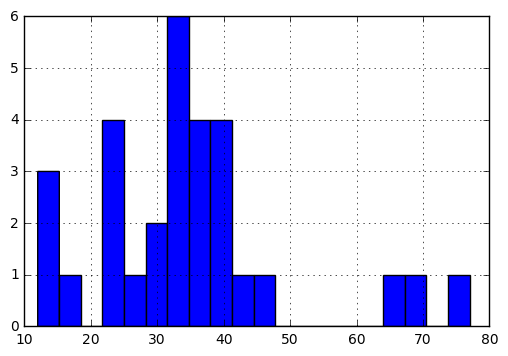

In [759]:
line_counts = df.groupby(['domain', 'doc_id']).size()
line_counts.hist(bins=20)
print 'Max Line: ', df["line"].max()

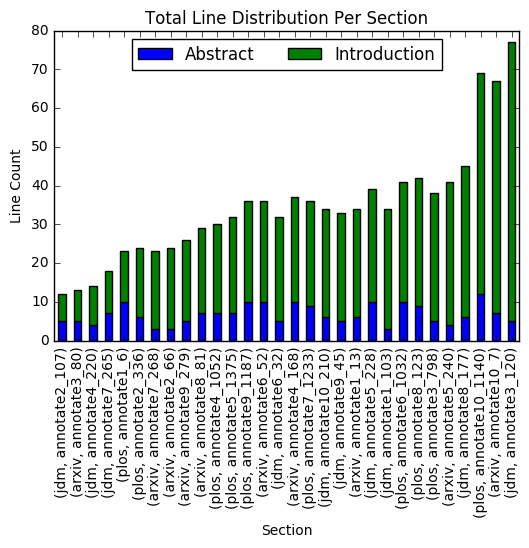

In [760]:
line_counts_by_section = df.groupby(['domain', 'doc_id', 'section']).size()
line_counts_by_section = line_counts_by_section.unstack()
my_plot = line_counts_by_section.sort_values(by=['introduction']).plot(kind='bar', stacked=True, title="Total Line Distribution Per Section")
my_plot.set_xlabel("Section")
my_plot.set_ylabel("Line Count")
my_plot.legend(["Abstract", "Introduction"], loc=9, ncol=4)

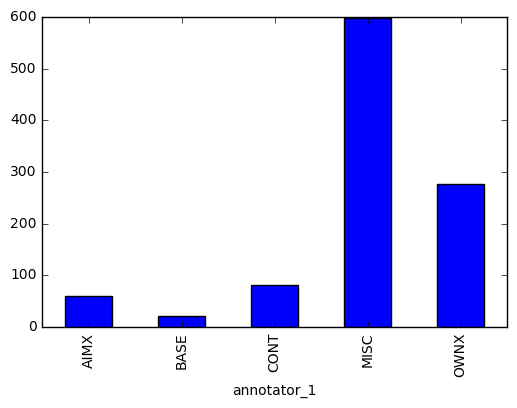

In [761]:
annotator_1 = df.groupby('annotator_1').size()
annotator_1.plot(kind='bar')

In [762]:
from sklearn.metrics import cohen_kappa_score
print cohen_kappa_score(df["annotator_1"], df["annotator_2"], labels=None)
print cohen_kappa_score(df["annotator_1"], df["annotator_3"], labels=None)
print cohen_kappa_score(df["annotator_2"], df["annotator_3"], labels=None)

0.763461385382
0.701940515493
0.71729096047


In [763]:
df_kappa = df[(df['annotator_1'] == 'AIMX') & (df['annotator_2'] == 'AIMX') & (df['annotator_3'] == 'AIMX')]
print len(df_kappa)
print cohen_kappa_score(df_kappa["annotator_1"], df_kappa["annotator_2"], labels=None)

39
nan


In [764]:
from collections import Counter
def calculate_label(a1, a2, a3):
    count = Counter([a1, a2, a3])
    if len(count) == 3:
        label = a3
    elif len(count) == 2 and a1 == a2:
        label = a2
    else:
        label = a3
    
    return label

In [765]:
df['final_label'] = df.apply(
        lambda row: calculate_label(row['annotator_1'], row['annotator_2'], row['annotator_3']), axis=1)

In [766]:
df = df.drop(["annotator_1", "annotator_2", "annotator_3"], axis=1)

In [767]:
df.groupby(["final_label"]).size()

final_label
AIMX     63
BASE     19
CONT     44
MISC    626
OWNX    287
dtype: int64

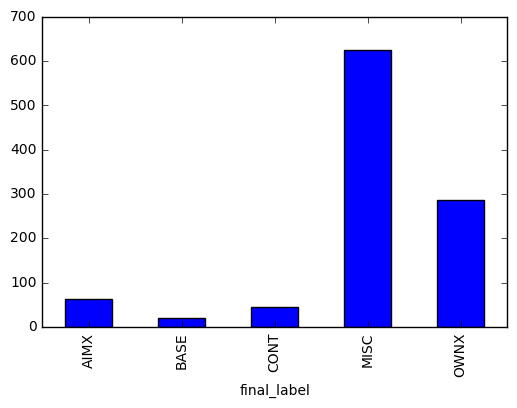

In [768]:
final_label = df.groupby('final_label').size()
final_label.plot(kind='bar')

In [769]:
import re
import string

def line_word_length(line):
    line.translate(None, string.punctuation)
    words = line.split()
    # words = re.split("[\p{Punct}\s]+", line)
    
    return len(words)
    

In [770]:
df['word_length'] = df['sentence'].apply(line_word_length)

In [771]:
df.iloc[45:50,:]

,domain,doc_id,line,section,sentence,final_label,word_length
45,arxiv,annotate10_7,51,introduction,A prior weight may then be defined by SYMBOL,MISC,9
46,arxiv,annotate10_7,52,introduction,If a string SYMBOL is generated by a Bernoul...,MISC,46
47,arxiv,annotate10_7,53,introduction,"That is, the two-part complexity with respect ...",MISC,20
48,arxiv,annotate10_7,54,introduction,Many Machine Learning tasks are or can be redu...,MISC,13
49,arxiv,annotate10_7,55,introduction,An important example is classification,MISC,5


In [772]:
def has_entity(line, entity):
    if entity in line:
        return 1
    else:
        return 0

In [773]:
df['has_citation'] = df['sentence'].apply(lambda row: has_entity(row, 'CITATION'))
df['has_symbol'] = df['sentence'].apply(lambda row: has_entity(row, 'SYMBOL'))
df['has_number'] = df['sentence'].apply(lambda row: has_entity(row, 'NUMBER'))

In [774]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["domain"] = encoder.fit_transform(df["domain"])
df["section"] = encoder.fit_transform(df["section"])

In [775]:
# df = df.drop(["has_symbol", "has_number", "has_citation"], axis=1)

In [776]:
df.corr(method='pearson')

,domain,line,section,word_length,has_citation,has_symbol,has_number
domain,1.000000,0.030831,-0.050690,0.165941,0.170548,-0.411161,-0.130037
line,0.030831,1.000000,0.532706,-0.011064,0.021309,-0.033907,-0.049572
section,-0.050690,0.532706,1.000000,0.059334,0.294906,0.026158,-0.018502
word_length,0.165941,-0.011064,0.059334,1.000000,0.264876,-0.040224,0.077633
has_citation,0.170548,0.021309,0.294906,0.264876,1.000000,-0.066644,-0.054024
has_symbol,-0.411161,-0.033907,0.026158,-0.040224,-0.066644,1.000000,-0.050957
has_number,-0.130037,-0.049572,-0.018502,0.077633,-0.054024,-0.050957,1.000000


In [777]:
df.skew()

domain         -0.073055
line            1.107134
section        -1.554344
word_length     1.011387
has_citation    1.018629
has_symbol      2.760846
has_number      6.220639
dtype: float64

In [778]:
df.describe()

,domain,line,section,word_length,has_citation,has_symbol,has_number
count,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000
mean,1.039461,21.008662,0.806545,24.653513,0.273340,0.095284,0.024062
std,0.820840,15.365581,0.395197,10.737957,0.445888,0.293748,0.153314
min,0.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,1.000000,17.000000,0.000000,0.000000,0.000000
50%,1.000000,18.000000,1.000000,23.000000,0.000000,0.000000,0.000000
75%,2.000000,29.000000,1.000000,30.000000,1.000000,0.000000,0.000000
max,2.000000,77.000000,1.000000,91.000000,1.000000,1.000000,1.000000


In [779]:
df.dtypes

domain           int64
doc_id          object
line             int64
section          int64
sentence        object
final_label     object
word_length      int64
has_citation     int64
has_symbol       int64
has_number       int64
dtype: object

In [782]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
df[['line', 'word_length']] = scaler.fit_transform(df[['line', 'word_length']])

In [783]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
def split_sentence_data(df):
    
    
    numeric_df = df.select_dtypes(include=['int64']).copy()
    
    
    #scaler = preprocessing.MinMaxScaler()
    #X = scaler.fit_transform(numeric_df)
    
    X = numeric_df.iloc[:].values
    y = df.iloc[:, 5].values

    return train_test_split(X, y, test_size=0.25, random_state=42)

In [784]:
X_train, X_test, y_train, y_test = split_sentence_data(df)

In [793]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1, 10]
    gammas = [0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    clf = svm.SVC(kernel='rbf')
    grid_search = GridSearchCV(clf, param_grid, cv=nfolds)
    grid_search.fit(X, y)
    
    return grid_search

In [790]:
from sklearn.metrics import classification_report
def test_results(clf, X_test, y_test):
    predictions = clf.predict(X_test)

    print "Accuracy is: ", clf.score(X_test, y_test)
    print classification_report(y_test, predictions)
    print "--------------------------"

In [794]:
grid_search = svc_param_selection(X_train, y_train, 10)

print grid_search.best_score_
print grid_search.best_params_

0.644415917843
{'C': 1, 'gamma': 1}


In [792]:
test_results(grid_search, X_test, y_test)

Accuracy is:  0.257692307692
             precision    recall  f1-score   support

       AIMX       0.18      0.41      0.25        22
       BASE       0.03      0.50      0.06         4
       CONT       0.05      0.22      0.09         9
       MISC       0.70      0.19      0.30       157
       OWNX       0.36      0.35      0.36        68

avg / total       0.53      0.26      0.30       260

--------------------------


In [788]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=4, min_samples_leaf=5)
clf.fit(X_train, y_train)
test_results(clf, X_test, y_test)

Accuracy is:  0.630769230769
             precision    recall  f1-score   support

       AIMX       0.00      0.00      0.00        22
       BASE       0.00      0.00      0.00         4
       CONT       0.00      0.00      0.00         9
       MISC       0.66      0.91      0.76       157
       OWNX       0.50      0.31      0.38        68

avg / total       0.53      0.63      0.56       260

--------------------------
